In [ ]:
#only for generating model card
!pip install --upgrade pip==21.3
!pip install -U seaborn scikit-learn model-card-toolkit

In [ ]:
# import model_card_toolkit as mctlib
!pip install datasets 
import torch
from torch import nn
import numpy as np
from datasets import load_dataset
import pandas as pd
! pip install -q kaggle
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
#dl data
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rmigonin","key":"3b04aa9357ae39a8d2f337363cda65dc"}'}

In [ ]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! chmod 600 /content/kaggle.json
! kaggle competitions download -c electricity-time-series-dataset-ml-winter-2022

! unzip electricity-time-series-dataset-ml-winter-2022.zip -d /content

In [ ]:
#load data

#train
train_data = pd.read_csv("/content/train.csv")
list_train_data = train_data[' "Sequence"'].tolist()

time_series_train = []
for i, row in enumerate(list_train_data):
  time_series_train.append(row.split(" "))
  time_series_train[i] = [float(i) for i in time_series_train[i]]

#test
test_data = pd.read_csv("/content/test.csv")
list_test_data = test_data["Sequence"].tolist()

time_series_test = []
for i, row in enumerate(list_test_data):
  time_series_test.append(row.split(" "))
  time_series_test[i] = [float(i) for i in time_series_test[i]]

#ids
list_test_IDs = test_data["Id"].tolist()


### Création du modèle

In [ ]:
class LSTNetModel(nn.Module):
  def __init__(self, input_lenght, output_lenght, num_users, ar_input_lenght):
    super(LSTNetModel, self).__init__() #needed for pytorch, apparently

    self.dropout = nn.Dropout(p= 0.2) #all values like this has been found empirically or on the original paper.

    #num_users is the number of time series
    self.num_conv_filters = 100 #number of filters for convolution
    self.num_variables = 1 #number of variables of our data, here 1 (electricty consumption)
    self.conv_filter_size = 6 #size of each filter for convolution (width)

    self.conv_out = self.num_conv_filters 
    self.n_user = num_users
    self.output_lenght = output_lenght
    self.input_lenght = input_lenght
    self.ar_input_lenght = ar_input_lenght


    #CNN part
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1, self.num_conv_filters, kernel_size=(self.num_variables, self.conv_filter_size)) #conv operation in CNN. \\ kernel shape = (n_variables, filter_size)

    #RNN part
    self.hidden_size_GRU = 100 #The number of features in the hidden state h for GRU, from original paper
    self.gru1 = nn.GRU(input_size=self.conv_out, hidden_size=self.hidden_size_GRU, batch_first=True) #GRU (gated reccurent unit) in RNN. Torch seem to use tanh, not RELU as in the paper. https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    #Reccurent skip part
    self.p = 24 #number of cells skipped, should be set as to have 24h periodicity
    self.hidden_size_GRUSkip = 100 #The number of features in the hidden state h for GRU Skip, from original paper

    self.gruSkip = nn.GRU(input_size=self.conv_out, hidden_size=self.hidden_size_GRUSkip, batch_first=True) #GRU (gated reccurent unit) in RNNSkip. Torch seem to use tanh, not RELU as in the paper. https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    #Dense layer to combine outputs
    # self.output_in_size = self.hidden_size_GRU + self.p * self.hidden_size_GRUSip
    self.RNNandRNNSkipLinear_in_size = self.hidden_size_GRU + self.hidden_size_GRUSkip * self.p
    self.RNNandRNNSkipLinear_out_size = output_lenght
    self.RNNandRNNSkipLinear = nn.Linear(self.RNNandRNNSkipLinear_in_size, self.RNNandRNNSkipLinear_out_size)

    #Autoregressive part
    self.fullyConnected = nn.Linear(ar_input_lenght, output_lenght)

  def forward(self,x):
    
    # print("input shape : ", x.shape)
    batch_size = x.size(0)

    #padding to ensure that output is just len(input) * dc (number of filters for cnn):
    if len(x) % 2 == 0 :
      x_padded = torch.nn.functional.pad(x, (self.conv_filter_size - 1,0,0,0), value=0)
    else:
      x_padded = torch.nn.functional.pad(x, (self.conv_filter_size ,0,0,0), value=0)


    # print("padded input shape : ", x_padded.shape)

    # ====== CNN ======
    #conv
    x_convoluted = x_padded.unsqueeze(1)
    x_convoluted = x_convoluted.unsqueeze(1)
    x_convoluted = self.conv1(x_convoluted)
    #relu
    x_output_CNN = self.relu(x_convoluted)
    x_output_CNN = self.dropout(x_output_CNN)
    x_output_CNN = x_output_CNN.squeeze(2) #remove height as it's one 
   
    # print("CNN output shape : ", x_output_CNN.shape)

    x_output_CNN_permuted = torch.permute(x_output_CNN, (0,2,1))
    
    # ====== RNN ======
    x_input_RNN = torch.permute(x_output_CNN, (0,2,1))
    # print("RNN input shape : ", x_input_RNN.shape)

    outputRNN, hidden_states_RNN = self.gru1(x_input_RNN)
    outputRNN = outputRNN[:, -1, :]
    outputRNN = self.dropout(outputRNN)

    # hidden_states_RNN = hidden_states_RNN.squeeze(0) 
    # outputRNN = outputRNN.squeeze(0) 

    # print("outputRNN ", outputRNN.shape)
    # print("hidden ", hidden_states_RNN.shape)


    # print("RNN hidden state shape : ", hidden_states_RNN.shape)
    # print("RNN outputRNN shape : ", outputRNN.shape)


    # ==== Reccurent_skip =====

    skip_sequence_len = input_lenght // self.p
    x_output_RNNSkip = x_output_CNN[:, :, -skip_sequence_len*self.p:] 
    x_output_RNNSkip = x_output_RNNSkip.view(x_output_RNNSkip.size(0), x_output_RNNSkip.size(1), skip_sequence_len, self.p)
    x_output_RNNSkip = x_output_RNNSkip.permute(0, 3, 2, 1).contiguous() 
    x_output_RNNSkip = x_output_RNNSkip.view(x_output_RNNSkip.size(0)*x_output_RNNSkip.size(1), x_output_RNNSkip.size(2), x_output_RNNSkip.size(3))  
    out, hidden = self.gruSkip(x_output_RNNSkip)
    x_output_RNNSkip = out[:, -1, :] 

    x_output_RNNSkip = x_output_RNNSkip.view(batch_size, self.p*x_output_RNNSkip.size(1))

    x_output_RNNSkip = self.dropout(x_output_RNNSkip)
    # print("output skip ", x_output_RNNSkip.shape)


    concat = torch.cat((outputRNN, x_output_RNNSkip), 1)


    # print("RNNSkip hidden state shape : ", hidden_states_RNNSkip.shape)
    # print("RNNSkip output shape : ", x_output_RNNSkip.shape)


    # ===== Autoregressive part ======
    x_input_AR = x[:,-self.ar_input_lenght:]
    autoregressive_output = self.fullyConnected(x_input_AR)
    # print("Autoregressive shape : ", autoregressive_output.shape)

    # ===== combining RNN and RNNSkip =====
    outputMainNet = self.relu(self.RNNandRNNSkipLinear(concat))
    # print("Output Main Net shape : ", outputMainNet.shape)



    # ===== return sum =====
    sum = outputMainNet + autoregressive_output
    return sum


### Création des batch

In [ ]:
#creates an ensemble of "batches" (not really) at different locations in the time series, with overlap.  Works better that way than creating normal batches.
def createAllBatches(data, batch_size, input_lenght, horizon):

  
  random_start = random.randint(0, horizon)
  # random_start = 0
  all_batches = []
  for start in range(0, len(max(data, key=len)), 5): #change step to control the distance between time series examples
    start_perturbed = random_start + start
    n_batch_skipped = 0
    batch = []
    targets = []
    index_list = list(range(batch_size))
    random.shuffle(index_list)
    for i in index_list:
      if len(data[i]) < (start_perturbed+input_lenght+horizon):
        n_batch_skipped +=1
      else:
        #input is end-start datapoints
        batch.append(data[i][start_perturbed:start_perturbed+input_lenght])
        #target is the next h datapoints
        targets.append(data[i][start_perturbed+input_lenght:start_perturbed+input_lenght+horizon])
    
    if n_batch_skipped < batch_size:
      all_batches.append((batch, targets))
    
  return all_batches



### Initialisation du modèle

In [ ]:
#INITIATE VALUES
input_lenght = 24*5 + 1
ar_input_lenght = 96 

# Output lenght / "predict at a time". It's a very important parameter. 
# A value too low means we predict too few values at a time, and errors accumulate. 
# A bigger value will need more data because the model will predict more at a time and be more complex.
h = 24 #Output lenght//paat

num_users = len(time_series_train)
num_epochs = 10
batch_size = 250


#INITIATE MODEL AND OPTIMIZER
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = LSTNetModel(input_lenght, h, num_users, ar_input_lenght)
model = model.to(device)

model_optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr is set as in original paper


#Loss : MSE Loss. Can implement more complex loss as in article for better results
criterion = nn.MSELoss() 

cuda:0


### Training

In [ ]:
#TRAINING
model.train();
time_series_train = np.array(time_series_train)
iter_loss = []
for j in tqdm(range(num_epochs)):
  batch_loss = []
  
  batches = createAllBatches(time_series_train, batch_size, input_lenght, h) # Input is just the last k data points
  for batch in batches: #up this to train on more datapoints
    input, targets = batch

    input = torch.Tensor(input).cuda()
    targets = torch.Tensor(targets).cuda()

    prediction = model(input)

    # print("prediction shape : ", prediction.shape)
    loss = criterion(prediction, targets)

    # Perform optimization
    model_optimizer.zero_grad()
    loss.backward()
    model_optimizer.step()
    batch_loss.append(loss.item())
  
  # print("Epoch :", j, " Loss : ", np.mean(batch_loss[-1])) 
  iter_loss.append(np.mean(batch_loss[-1]))


100%|██████████| 10/10 [20:19<00:00, 121.91s/it]


In [ ]:
 # Utility function that will export a plot to a base-64 encoded string that the model card will accept.
import uuid
import base64
from io import BytesIO
def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')
 
plt.xlabel("epoch")
plt.ylabel("Loss MSE")
plt.title("MSE loss during training on train set")
plt.plot(iter_loss)
iter_loss_str = plot_to_str()

### Evaluation et prédictions

In [ ]:
import copy
time_series_test_copy = copy.deepcopy(time_series_test)

We predict the values, until we get a prediction that is 120 long (5 days). If we set h to 24 for example, it will predict 24h with the previous *input_lenght* values, and then add them to the time serie. The next 24h will be predict with the previous 24h predicted and the leftover from the original time serie. Other strategies exist and has been tested, this proved to be the best one for our case.

In [ ]:
predictions = []

model.eval()

for time_serie in tqdm(time_series_test_copy):
  res = []
  t = copy.deepcopy(time_serie)

  for period in range(120//h):

    input = torch.Tensor(t[-input_lenght:])
    input = input.unsqueeze(0).cuda()
    with torch.no_grad():
      pred = model(input)
    pred = pred.squeeze(0).tolist()

    res = res + pred
    t = t + pred

  predictions.append(res)


# predictions = []
# predict_at_a_time = 24

# model.eval()
# print(len(time_series_test_copy))
# for time_serie in tqdm(time_series_test_copy):
#   res = []
#   for period in range(120//h):

#     t = time_serie
    
#     input = torch.Tensor(t[-input_lenght:])
#     input = input.unsqueeze(0).cuda()
#     with torch.no_grad():
#       pred = model(input)
#     pred = pred.squeeze(0).tolist()

#     res = res + pred
#   predictions.append(res)

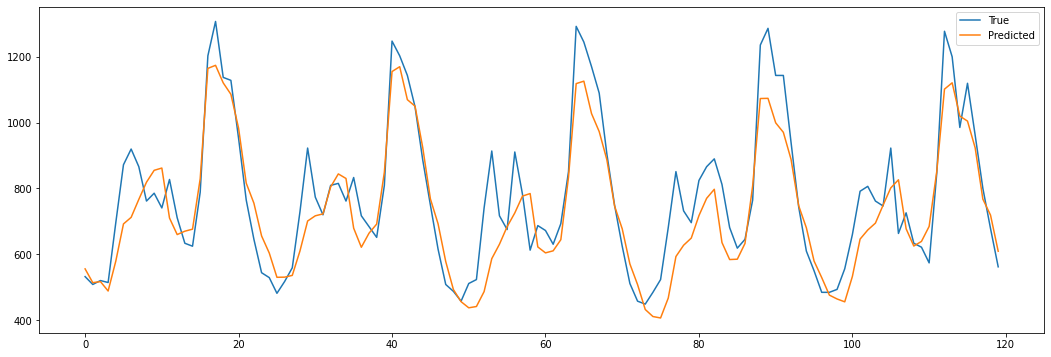

In [ ]:
#display a prediction on a test serie, predicting the last 120 values and comparing them with the actual values. For visualisations purpose
start = 600
time_serie = copy.deepcopy(time_series_test_copy[1115])
y_true = copy.deepcopy(time_serie[start:start+120])
t = copy.deepcopy(time_serie[start-input_lenght:start])

res = []
model.eval()
for i in range(1,2):

  for period in range(120//h):

    
    input = torch.Tensor(t[-input_lenght:])
    input = input.unsqueeze(0).cuda()
    with torch.no_grad():
      pred = model(input)
    pred = pred.squeeze(0).tolist()

    res = res + pred
    t = t + pred

plt.rcParams['figure.figsize'] = [18, 6]
plt.plot(y_true, label="True")
plt.plot(res, label="Predicted")
plt.legend()

pred_visu_str = plot_to_str()

### Soumissions des résultats sur Kaggle

In [ ]:
dic = {"Id": list_test_IDs}
predictions = np.array(predictions)
print(predictions.shape)
for i in range(120):
  dic["Prediction_"+str(i+1)] = predictions[:,i]

df = pd.DataFrame(data=dic)
print(df.info())
df.to_csv("submission.csv", index=False)

(3700, 120)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Columns: 121 entries, Id to Prediction_120
dtypes: float64(120), int64(1)
memory usage: 3.4 MB
None


In [ ]:
print("ar:"+str(ar_input_lenght)+", il:"+str(input_lenght)+", bs:"+str(batch_size)+", epoch:"+str(num_epochs)+", rd:True, paat: "+str(h) + " pred:corrected")

ar:96, il:121, bs:250, epoch:10, rd:True, paat: 24 pred:corrected


In [ ]:
 !kaggle competitions submit -c electricity-time-series-dataset-ml-winter-2022 -f submission.csv -m "ar:96, il:121, bs:250, epoch:10, rd:True, paat: 24 pred: corrected"

100% 7.55M/7.55M [00:05<00:00, 1.44MB/s]
Successfully submitted to Electricity Time Series dataset - ML Winter 2022

### MODEL CARD

In [ ]:
from datetime import date


#init
mct = mctlib.ModelCardToolkit()

model_card = mct.scaffold_assets()

In [ ]:
# model_card.model_parameters


model_card.model_details.name = 'LSTNet implementation for electricity dataset'
model_card.model_details.overview = (
    "This model predicts the next 5 days of hourly electricity consumption given a electricity consumption time series input." + "\n" + "\n It is based on LSTNet, \
    a deep learning framework for univariate and multivariate time series prediction. It uses both a CNN layer and RNN layers, which makes it very interesting to implement to learn those NNs. \
    The goal of LSTNet is to capture both long term trends and short term trends to make accurate predictions, with a relatively long horizon. "
    "It is trained on the electricity load diagrams dataset. The training set includes the electricity consumption of 250 users from 2011 to 2014, hourly. It is univariate : only one variable is given for every timestep (electrity consumption).")

model_card.model_details.owners = [
    mctlib.Owner(name= 'Rémi Gonin', contact="remi.gonin@polymtl.ca"),
    mctlib.Owner(name= 'Augustin Barruol', contact="augustin.barruol@polymtl.ca")
]
model_card.model_details.references = [
    mctlib.Reference(reference='https://arxiv.org/abs/1703.07015'),
    mctlib.Reference(reference='https://github.com/huggingface/datasets/tree/master/datasets/electricity_load_diagrams')
]

model_card.model_details.version.date = str(date.today())


model_card.considerations.limitations = [mctlib.Limitation(description='Low flexibility due to RNNSkip part : skip-lenght is specific to this task (electricity consumption). It\'s possible to find one as in the original paper if skip lenght is unclear.'), 
                                         mctlib.Limitation(description='Outdated method : More performing frameworks than LSTNet are out (Informer, SciNet...)'), 
                                         mctlib.Limitation(description='Specialization : LSTNet does not specialize in univariate time series prediction, but in both univariate and multivariate. Here, we only predict univariate time series.'),
                                         mctlib.Limitation(description='Long training : Our model seems to require a lot of training data and time to perform'),
                                         mctlib.Limitation(description='Complexity : A lot of hyperparameters need tuning')
                                      
                                         
                                         ]
model_card.considerations.use_cases = [mctlib.UseCase(description='Time series prediction for more intelligent production and distribution of energy')]


model_card.model_parameters.data.append(mctlib.Dataset())
# model_card.model_parameters.data[0].graphics.description = (
#   f'test')
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(name= 'test', image=pred_visu_str)
]

# model_card.model_parameters.data.append(mctlib.Dataset())
# model_card.model_parameters.data[1].graphics.description = (
#   "aaa")
# model_card.model_parameters.data[1].graphics.collection = [
#     mctlib.Graphic(image=iter_loss_str)
# ]

# model_card.quantitative_analysis.graphics.description = (
#   'ROC curve and confusion matrix')
# model_card.quantitative_analysis.graphics.collection = [
#     mctlib.Graphic(image=iter_loss_str),
#     mctlib.Graphic(image=iter_loss_str)
# ]


mct.update_model_card(model_card)

In [ ]:
# Return the model card document as an HTML page
from IPython import display

html = mct.export_format()

display.display(display.HTML(html))